In [1]:
import pandas as pd
import os
from dotenv import load_dotenv
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from data_prep.topic_modeling.process_articles import *

In [2]:
# define constants 
NTT_PATH = "./data/ntt_data/{}.csv"
COVID_PATH = "./data/covid_data/{}.csv"
WEATHER_PATH = "./data/weather/{}.csv"
NEWS_PATH = "./data/news/{}.csv"

In [3]:
articles = pd.read_csv(NEWS_PATH.format("articles_filtered_by_topic"))
articles.head()


,date,title,text,publication,topic
0,2020-01-17,新型肺炎：神奈川の男性、新型肺炎 国内初確認 武漢渡航、既に退院,厚生労働省は１６日、中国の武漢市に滞在歴のある神奈川県在住の３０代男性が肺炎の症状を起こし...,mainichi,0
1,2020-01-21,新型肺炎：新型肺炎 ヒトからヒト確認 中国で死者３人、感染２００人超,中国湖北省武漢市の衛生当局は２０日、２０１９年末から集団感染の広がる新型コロナウイルスによ...,mainichi,0
2,2020-01-21,ヒトからヒトへ、新型肺炎が感染 中国明言,中国中部の湖北省武漢市で集団発生している新型コロナウイルスによる肺炎をめぐり、中国政府の専門...,asahi,0
3,2020-01-22,新型肺炎 出入り制限 中国・武漢 人から人 感染確認 死者６人に,【上海＝南部さやか】中国湖北省武漢市を中心に多発する新型コロナウイルスによる肺炎で、武漢市...,yomiuri,0
4,2020-01-22,新型肺炎：新型肺炎 上海から入国も体調申告を要請 政府対応強化,政府は２１日、対策を協議する関係閣僚会議を開いた。武漢に加え、上海からの入国者に、体調や薬...,mainichi,-1


In [47]:
cov_articles = filter_kansenshasuu_articles(articles)
cov_articles['date'] = pd.to_datetime(cov_articles['date'])
cov_articles = pd.DataFrame(cov_articles.groupby('date')['num_publications_reporting'].first())
urgency_scores = cov_articles.rename(columns={"num_publications_reporting": "news_urgency"})
urgency_scores.to_csv(NEWS_PATH.format("urgency_scores"))

In [5]:
shibs_df = pd.read_csv(NTT_PATH.format("shibuya_station_1_refined_binned"))
shibs_daytime = shibs_df[shibs_df["time_bin"] == "800-1700"].reset_index(drop=True)
shibs_daytime["population_log"] = shibs_daytime["population"].apply(math.log)
shibs_daytime["date"] = pd.to_datetime(shibs_daytime["date"])
shibs_daytime

,date,population,rain(mm),temp,day_of_week,time,total_new_cases,tokyo_new_cases,total_weekly_diff,tokyo_weekly_diff,...,holiday,time_bin,weather_1,weather_2,weather_3,weather_4,weather_9,weather_10,weather_15,population_log
0,2020-01-01,58693.555556,0.0,7.422222,13,800,NaN,NaN,NaN,NaN,...,1,800-1700,1,0,0,0,0,0,0,10.980085
1,2020-01-02,89257.333333,0.0,8.433333,14,800,NaN,NaN,NaN,NaN,...,0,800-1700,1,0,0,0,0,0,0,11.399279
2,2020-01-03,102033.777778,0.0,8.688889,15,800,NaN,NaN,NaN,NaN,...,0,800-1700,1,0,0,0,0,0,0,11.533059
3,2020-01-04,122410.777778,0.0,9.511111,16,800,NaN,NaN,NaN,NaN,...,0,800-1700,0,1,0,0,0,0,0,11.715138
4,2020-01-05,126135.222222,0.0,7.955556,17,800,NaN,NaN,NaN,NaN,...,0,800-1700,1,0,0,0,0,0,0,11.745110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2021-12-27,188424.000000,0.0,5.422222,11,800,132.0,37.0,60.0,29.0,...,0,800-1700,1,0,0,0,0,0,0,12.146450
727,2021-12-28,177718.555556,0.0,6.444444,12,800,347.0,56.0,140.0,20.0,...,0,800-1700,1,0,0,0,0,0,0,12.087956
728,2021-12-29,137780.000000,0.0,5.844444,13,800,447.0,84.0,210.0,50.0,...,0,800-1700,0,1,0,0,0,0,0,11.833413
729,2021-12-30,115233.444444,0.0,9.988889,14,800,435.0,78.0,157.0,39.0,...,0,800-1700,1,0,0,0,0,0,0,11.654715


In [6]:
shibs_daytime = shibs_daytime.merge(cov_articles, how="left", on="date")
shibs_daytime["num_publications_reporting"] = shibs_daytime["num_publications_reporting"].fillna(0).apply(int)
shibs_daytime

,date,population,rain(mm),temp,day_of_week,time,total_new_cases,tokyo_new_cases,total_weekly_diff,tokyo_weekly_diff,...,time_bin,weather_1,weather_2,weather_3,weather_4,weather_9,weather_10,weather_15,population_log,num_publications_reporting
0,2020-01-01,58693.555556,0.0,7.422222,13,800,NaN,NaN,NaN,NaN,...,800-1700,1,0,0,0,0,0,0,10.980085,0
1,2020-01-02,89257.333333,0.0,8.433333,14,800,NaN,NaN,NaN,NaN,...,800-1700,1,0,0,0,0,0,0,11.399279,0
2,2020-01-03,102033.777778,0.0,8.688889,15,800,NaN,NaN,NaN,NaN,...,800-1700,1,0,0,0,0,0,0,11.533059,0
3,2020-01-04,122410.777778,0.0,9.511111,16,800,NaN,NaN,NaN,NaN,...,800-1700,0,1,0,0,0,0,0,11.715138,0
4,2020-01-05,126135.222222,0.0,7.955556,17,800,NaN,NaN,NaN,NaN,...,800-1700,1,0,0,0,0,0,0,11.745110,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2021-12-27,188424.000000,0.0,5.422222,11,800,132.0,37.0,60.0,29.0,...,800-1700,1,0,0,0,0,0,0,12.146450,2
727,2021-12-28,177718.555556,0.0,6.444444,12,800,347.0,56.0,140.0,20.0,...,800-1700,1,0,0,0,0,0,0,12.087956,1
728,2021-12-29,137780.000000,0.0,5.844444,13,800,447.0,84.0,210.0,50.0,...,800-1700,0,1,0,0,0,0,0,11.833413,1
729,2021-12-30,115233.444444,0.0,9.988889,14,800,435.0,78.0,157.0,39.0,...,800-1700,1,0,0,0,0,0,0,11.654715,0


In [7]:
shibs_daytime.columns

Index(['date', 'population', 'rain(mm)', 'temp', 'day_of_week', 'time',
       'total_new_cases', 'tokyo_new_cases', 'total_weekly_diff',
       'tokyo_weekly_diff', 'total_severe_cases', 'tokyo_severe_cases',
       'total_cum_deaths', 'tokyo_cum_deaths', 'total_daily_deaths',
       'tokyo_daily_deaths', 'soe1', 'soe2', 'soe3', 'soe4', 'semi-soe1',
       'semi-soe2', 'wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'holiday', 'time_bin', 'weather_1', 'weather_2',
       'weather_3', 'weather_4', 'weather_9', 'weather_10', 'weather_15',
       'population_log', 'num_publications_reporting'],
      dtype='object')

In [8]:
# set date as index
shibs_daytime.set_index('date', inplace=True)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# create lag variables
shibs_daytime['population_lag'] = shibs_daytime['population'].shift(1)
shibs_daytime['population_log_lag'] = shibs_daytime['population_log'].shift(1)
shibs_daytime['total_new_cases_lag'] = shibs_daytime['total_new_cases'].shift(1)
shibs_daytime['tokyo_new_cases_lag'] = shibs_daytime['tokyo_new_cases'].shift(1)
shibs_daytime['tokyo_new_cases_week_lag'] = shibs_daytime['tokyo_new_cases'].shift(7)
shibs_daytime['total_weekly_diff_lag'] = shibs_daytime['total_weekly_diff'].shift(1)
shibs_daytime['tokyo_weekly_diff_lag'] = shibs_daytime['tokyo_weekly_diff'].shift(1)
shibs_daytime['total_severe_cases_lag'] = shibs_daytime['total_severe_cases'].shift(1)
shibs_daytime['tokyo_severe_cases_lag'] = shibs_daytime['tokyo_severe_cases'].shift(1)
shibs_daytime['total_cum_deaths_lag'] = shibs_daytime['total_cum_deaths'].shift(1)
shibs_daytime['tokyo_cum_deaths_lag'] = shibs_daytime['tokyo_cum_deaths'].shift(1)
shibs_daytime['total_daily_deaths_lag'] = shibs_daytime['total_daily_deaths'].shift(1)
shibs_daytime['tokyo_daily_deaths_lag'] = shibs_daytime['tokyo_daily_deaths'].shift(1)

mask = ['population', 'population_lag', 'population_log', 'population_log_lag', 
        'total_new_cases_lag', 'holiday', 'tokyo_new_cases_lag', 'total_weekly_diff_lag', 
        'tokyo_weekly_diff_lag', 'tokyo_new_cases_week_lag']

# add weather dummies
mask += list(shibs_daytime.columns[shibs_daytime.columns.str.contains(r"weather_\d+")])

# add soe dummies
mask += list(shibs_daytime.columns[shibs_daytime.columns.str.contains(r"soe\d+")])

# add wave dummies
mask += list(shibs_daytime.columns[shibs_daytime.columns.str.contains(r"wave\d+")])

# add weekday dummies
mask += list(shibs_daytime.columns[shibs_daytime.columns.str.contains(r"weekday_\d+")])

print(mask) 

# prepare data for linear regression
reg_df = shibs_daytime[mask]

reg_df = reg_df.dropna(axis=0)

# REMOVED FOLLOWING DUE TO NA VALUES 
    # 'total_severe_cases_lag',
    # 'tokyo_severe_cases_lag',
    # 'total_cum_deaths_lag',
    # 'tokyo_cum_deaths_lag',
    # 'total_daily_deaths_lag', 
    # 'tokyo_daily_deaths_lag',

['population', 'population_lag', 'population_log', 'population_log_lag', 'total_new_cases_lag', 'holiday', 'tokyo_new_cases_lag', 'total_weekly_diff_lag', 'tokyo_weekly_diff_lag', 'tokyo_new_cases_week_lag', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'weather_9', 'weather_10', 'weather_15', 'soe1', 'soe2', 'soe3', 'soe4', 'semi-soe1', 'semi-soe2', 'wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']


In [9]:
reg_df

,population,population_lag,population_log,population_log_lag,total_new_cases_lag,holiday,tokyo_new_cases_lag,total_weekly_diff_lag,tokyo_weekly_diff_lag,tokyo_new_cases_week_lag,...,wave3,wave4,wave5,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,
2020-01-23,217496.555556,221899.444444,12.289938,12.309980,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2020-01-24,220544.777778,217496.555556,12.303856,12.289938,0.0,0,0.0,-1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2020-01-25,160022.444444,220544.777778,11.983069,12.303856,1.0,0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2020-01-26,144201.555556,160022.444444,11.878967,11.983069,1.0,0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2020-01-27,211337.444444,144201.555556,12.261211,11.878967,1.0,0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,188424.000000,143624.000000,12.146450,11.874954,215.0,0,35.0,58.0,4.0,8.0,...,0,0,1,1,0,0,0,0,0,0
2021-12-28,177718.555556,188424.000000,12.087956,12.146450,132.0,0,37.0,60.0,29.0,36.0,...,0,0,1,0,1,0,0,0,0,0
2021-12-29,137780.000000,177718.555556,11.833413,12.087956,347.0,0,56.0,140.0,20.0,34.0,...,0,0,1,0,0,1,0,0,0,0


In [10]:
# add urgency score to reg_df 
# create urgency dummy
cov_articles["urgency"] = cov_articles["num_publications_reporting"].apply(lambda x: int(x>=3))

reg_df1 = reg_df.merge(cov_articles, how="left", on="date")
reg_df1['urgency'] = reg_df1['urgency'].fillna(0).apply(int)
reg_df1['num_publications_reporting'] = reg_df1['num_publications_reporting'].fillna(0).apply(int)
reg_df1

,population,population_lag,population_log,population_log_lag,total_new_cases_lag,holiday,tokyo_new_cases_lag,total_weekly_diff_lag,tokyo_weekly_diff_lag,tokyo_new_cases_week_lag,...,wave5,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,num_publications_reporting,urgency
date,,,,,,,,,,,,,,,,,,,,,
2020-01-23,217496.555556,221899.444444,12.289938,12.309980,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,3,1
2020-01-24,220544.777778,217496.555556,12.303856,12.289938,0.0,0,0.0,-1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,2,0
2020-01-25,160022.444444,220544.777778,11.983069,12.303856,1.0,0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,0,3,1
2020-01-26,144201.555556,160022.444444,11.878967,11.983069,1.0,0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,3,1
2020-01-27,211337.444444,144201.555556,12.261211,11.878967,1.0,0,0.0,1.0,0.0,0.0,...,0,1,0,0,0,0,0,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,188424.000000,143624.000000,12.146450,11.874954,215.0,0,35.0,58.0,4.0,8.0,...,1,1,0,0,0,0,0,0,2,0
2021-12-28,177718.555556,188424.000000,12.087956,12.146450,132.0,0,37.0,60.0,29.0,36.0,...,1,0,1,0,0,0,0,0,1,0
2021-12-29,137780.000000,177718.555556,11.833413,12.087956,347.0,0,56.0,140.0,20.0,34.0,...,1,0,0,1,0,0,0,0,1,0


In [11]:
reg_df1 = reg_df1.dropna(axis=0)
reg_df1

,population,population_lag,population_log,population_log_lag,total_new_cases_lag,holiday,tokyo_new_cases_lag,total_weekly_diff_lag,tokyo_weekly_diff_lag,tokyo_new_cases_week_lag,...,wave5,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,num_publications_reporting,urgency
date,,,,,,,,,,,,,,,,,,,,,
2020-01-23,217496.555556,221899.444444,12.289938,12.309980,0.0,0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,3,1
2020-01-24,220544.777778,217496.555556,12.303856,12.289938,0.0,0,0.0,-1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,2,0
2020-01-25,160022.444444,220544.777778,11.983069,12.303856,1.0,0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,0,3,1
2020-01-26,144201.555556,160022.444444,11.878967,11.983069,1.0,0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,3,1
2020-01-27,211337.444444,144201.555556,12.261211,11.878967,1.0,0,0.0,1.0,0.0,0.0,...,0,1,0,0,0,0,0,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,188424.000000,143624.000000,12.146450,11.874954,215.0,0,35.0,58.0,4.0,8.0,...,1,1,0,0,0,0,0,0,2,0
2021-12-28,177718.555556,188424.000000,12.087956,12.146450,132.0,0,37.0,60.0,29.0,36.0,...,1,0,1,0,0,0,0,0,1,0
2021-12-29,137780.000000,177718.555556,11.833413,12.087956,347.0,0,56.0,140.0,20.0,34.0,...,1,0,0,1,0,0,0,0,1,0


In [12]:
# select the columns to use as features and target
# start with unlogged values
X = reg_df1.drop(['population_log', 'population_log_lag', 'population'], axis=1)
y = reg_df1['population']
X

,population_lag,total_new_cases_lag,holiday,tokyo_new_cases_lag,total_weekly_diff_lag,tokyo_weekly_diff_lag,tokyo_new_cases_week_lag,weather_1,weather_2,weather_3,...,wave5,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,num_publications_reporting,urgency
date,,,,,,,,,,,,,,,,,,,,,
2020-01-23,221899.444444,0.0,0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,3,1
2020-01-24,217496.555556,0.0,0,0.0,-1.0,0.0,0.0,0,0,0,...,0,0,0,0,0,1,0,0,2,0
2020-01-25,220544.777778,1.0,0,1.0,1.0,1.0,0.0,0,0,0,...,0,0,0,0,0,0,1,0,3,1
2020-01-26,160022.444444,1.0,0,1.0,1.0,1.0,0.0,0,0,0,...,0,0,0,0,0,0,0,1,3,1
2020-01-27,144201.555556,1.0,0,0.0,1.0,0.0,0.0,0,0,0,...,0,1,0,0,0,0,0,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,143624.000000,215.0,0,35.0,58.0,4.0,8.0,1,0,0,...,1,1,0,0,0,0,0,0,2,0
2021-12-28,188424.000000,132.0,0,37.0,60.0,29.0,36.0,1,0,0,...,1,0,1,0,0,0,0,0,1,0
2021-12-29,177718.555556,347.0,0,56.0,140.0,20.0,34.0,0,1,0,...,1,0,0,1,0,0,0,0,1,0


In [13]:
import statsmodels.api as sm

# add constant to the model
X = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

# summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             population   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     231.6
Date:                Mon, 30 Jan 2023   Prob (F-statistic):               0.00
Time:                        18:08:14   Log-Likelihood:                -7611.6
No. Observations:                 709   AIC:                         1.529e+04
Df Residuals:                     678   BIC:                         1.543e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [14]:
# get rid of urgency, total new cases, total_ weekly_diff, tokyo_weekly_diff
X = reg_df1.drop(['population_log', 'population_log_lag', 'population', 'urgency', 'total_new_cases_lag', 'total_weekly_diff_lag', 'tokyo_weekly_diff_lag'], axis=1)
y = reg_df1['population']
X

,population_lag,holiday,tokyo_new_cases_lag,tokyo_new_cases_week_lag,weather_1,weather_2,weather_3,weather_4,weather_9,weather_10,...,wave4,wave5,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,num_publications_reporting
date,,,,,,,,,,,,,,,,,,,,,
2020-01-23,221899.444444,0,0.0,0.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,3
2020-01-24,217496.555556,0,0.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,2
2020-01-25,220544.777778,0,1.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,3
2020-01-26,160022.444444,0,1.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,3
2020-01-27,144201.555556,0,0.0,0.0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,143624.000000,0,35.0,8.0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,2
2021-12-28,188424.000000,0,37.0,36.0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
2021-12-29,177718.555556,0,56.0,34.0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [15]:
# add constant to the model
X = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

# summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             population   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     267.6
Date:                Mon, 30 Jan 2023   Prob (F-statistic):               0.00
Time:                        18:08:14   Log-Likelihood:                -7613.0
No. Observations:                 709   AIC:                         1.528e+04
Df Residuals:                     682   BIC:                         1.540e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [16]:
# now do the same but with logged variables 
# get rid of urgency, total new cases, total_ weekly_diff, tokyo_weekly_diff
X = reg_df1.drop(['population', 'population_lag', 'population_log', 'urgency', 'total_new_cases_lag', 'total_weekly_diff_lag', 'tokyo_weekly_diff_lag'], axis=1)
y = reg_df1['population_log']
X

,population_log_lag,holiday,tokyo_new_cases_lag,tokyo_new_cases_week_lag,weather_1,weather_2,weather_3,weather_4,weather_9,weather_10,...,wave4,wave5,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,num_publications_reporting
date,,,,,,,,,,,,,,,,,,,,,
2020-01-23,12.309980,0,0.0,0.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,3
2020-01-24,12.289938,0,0.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,2
2020-01-25,12.303856,0,1.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,3
2020-01-26,11.983069,0,1.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,3
2020-01-27,11.878967,0,0.0,0.0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,11.874954,0,35.0,8.0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,2
2021-12-28,12.146450,0,37.0,36.0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
2021-12-29,12.087956,0,56.0,34.0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [17]:
# add constant to the model
X = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

# summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         population_log   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     251.4
Date:                Mon, 30 Jan 2023   Prob (F-statistic):               0.00
Time:                        18:08:14   Log-Likelihood:                 708.92
No. Observations:                 709   AIC:                            -1364.
Df Residuals:                     682   BIC:                            -1241.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [18]:
def perform_regression(filename: str, time_bin: str):
    # read articles into dataframe 
    cov_articles = filter_kansenshasuu_articles(articles)
    cov_articles['date'] = pd.to_datetime(cov_articles['date'])
    cov_articles = pd.DataFrame(cov_articles.groupby('date')['num_publications_reporting'].first())

    # read ntt data
    df = pd.read_csv(NTT_PATH.format(filename))
    # set time_bin
    daytime = df[df["time_bin"] == time_bin].reset_index(drop=True)
    # add population_log 
    daytime["population_log"] = daytime["population"].apply(math.log)
    # convert date to datetime 
    daytime["date"] = pd.to_datetime(daytime["date"])
    # merge ntt and articles df 
    daytime = daytime.merge(cov_articles, how="left", on="date")
    daytime["num_publications_reporting"] = daytime["num_publications_reporting"].fillna(0).apply(int)
    # set date as index
    daytime.set_index('date', inplace=True)
    # create lag variables
    daytime['population_lag'] = daytime['population'].shift(1)
    daytime['population_log_lag'] = daytime['population_log'].shift(1)
    daytime['tokyo_new_cases_lag'] = daytime['tokyo_new_cases'].shift(1)
    daytime['tokyo_new_cases_week_lag'] = daytime['tokyo_new_cases'].shift(7)
    
    # get regression data 
    mask = ['population', 'population_lag', 'population_log', 'population_log_lag', 
            'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag']

    # add weather dummies
    mask += list(daytime.columns[daytime.columns.str.contains(r"weather_\d+")])

    # add soe dummies
    mask += list(daytime.columns[daytime.columns.str.contains(r"soe\d+")])

    # add wave dummies
    mask += list(daytime.columns[daytime.columns.str.contains(r"wave\d+")])

    # add weekday dummies
    mask += list(daytime.columns[daytime.columns.str.contains(r"weekday_\d+")])

    print(mask) 

    # prepare data for linear regression
    reg_df = daytime[mask]

    reg_df = reg_df.dropna(axis=0)

    # add urgency score to reg_df 
    # create urgency dummy
    cov_articles["urgency"] = cov_articles["num_publications_reporting"].apply(lambda x: int(x>=3))

    reg_df1 = reg_df.merge(cov_articles, how="left", on="date")
    reg_df1['urgency'] = reg_df1['urgency'].fillna(0).apply(int)
    reg_df1['num_publications_reporting'] = reg_df1['num_publications_reporting'].fillna(0).apply(int)
    
    reg_df1 = reg_df1.dropna(axis=0)

    # get rid of urgency, total new cases, total_ weekly_diff, tokyo_weekly_diff
    X = reg_df1.drop(['population_log', 'population_log_lag', 'population', 'urgency'], axis=1)
    y = reg_df1['population']
    
    # add constant to the model
    X = sm.add_constant(X)

    # fit the model
    model = sm.OLS(y, X).fit()

    # summary of the model
    print(model.summary())

    # now do the same but with logged variables 
    # get rid of urgency, total new cases, total_ weekly_diff, tokyo_weekly_diff
    X = reg_df1.drop(['population', 'population_lag', 'population_log', 'urgency'], axis=1)
    y = reg_df1['population_log']
    
    # add constant to the model
    X = sm.add_constant(X)

    # fit the model
    model_log = sm.OLS(y, X).fit()

    # summary of the model
    print(model_log.summary())

    reg_df2 = reg_df.merge(cov_articles, how="left", on="date")
    reg_df2['urgency'] = reg_df2['urgency'].fillna(0).apply(int)
    reg_df2['num_publications_reporting'] = reg_df2['num_publications_reporting'].fillna(0).apply(int)
    
    reg_df2 = reg_df2.dropna(axis=0)

    # Create interaction columns for each interaction between a wave and num_publications_reporting
    for wave in ['wave1', 'wave2', 'wave3', 'wave4', 'wave5']:
        reg_df2[f"{wave}_x_num_publications_reporting"] = reg_df2[wave] * reg_df2["num_publications_reporting"]

    # get rid of urgency, total new cases, total_ weekly_diff, tokyo_weekly_diff
    X = reg_df2.drop(['population', 'population_lag', 'population_log', 'urgency'], axis=1)
    y = reg_df2['population_log']

    # add constant to the model
    X = sm.add_constant(X)

    # fit the model
    model_interactions = sm.OLS(y, X).fit()

    # summary of the model
    print(model_interactions.summary())



    return (model, model_log, model_interactions)



In [19]:
perform_regression('shibuya_station_1_refined_binned', '800-1700')

['population', 'population_lag', 'population_log', 'population_log_lag', 'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'weather_9', 'weather_10', 'weather_15', 'soe1', 'soe2', 'soe3', 'soe4', 'semi-soe1', 'semi-soe2', 'wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
                            OLS Regression Results                            
Dep. Variable:             population   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     267.6
Date:                Mon, 30 Jan 2023   Prob (F-statistic):               0.00
Time:                        18:08:14   Log-Likelihood:                -7613.0
No. Observations:                 709   AIC:                         1.528e+04
Df Residuals:            

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x17b722290>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x17b6f5390>)

In [20]:
perform_regression('tokyo_ootemachi_refined_binned', '800-1700')

['population', 'population_lag', 'population_log', 'population_log_lag', 'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'weather_9', 'weather_10', 'weather_15', 'soe1', 'soe2', 'soe3', 'soe4', 'semi-soe1', 'semi-soe2', 'wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
                            OLS Regression Results                            
Dep. Variable:             population   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     235.8
Date:                Mon, 30 Jan 2023   Prob (F-statistic):          2.60e-320
Time:                        18:08:14   Log-Likelihood:                -8141.4
No. Observations:                 709   AIC:                         1.634e+04
Df Residuals:            

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x17b6f5270>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x17b78fd90>)

In [21]:
perform_regression('mitaka_refined_binned', '800-1700')

['population', 'population_lag', 'population_log', 'population_log_lag', 'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'weather_9', 'weather_10', 'weather_15', 'soe1', 'soe2', 'soe3', 'soe4', 'semi-soe1', 'semi-soe2', 'wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
                            OLS Regression Results                            
Dep. Variable:             population   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     174.9
Date:                Mon, 30 Jan 2023   Prob (F-statistic):          2.40e-281
Time:                        18:08:15   Log-Likelihood:                -5805.3
No. Observations:                 709   AIC:                         1.166e+04
Df Residuals:            

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x17b7982e0>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x17b711210>)

/var/folders/00/2zkqvc3n5y37rp1f1p9qc_5r0000gn/T/ipykernel_76306/3728364571.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


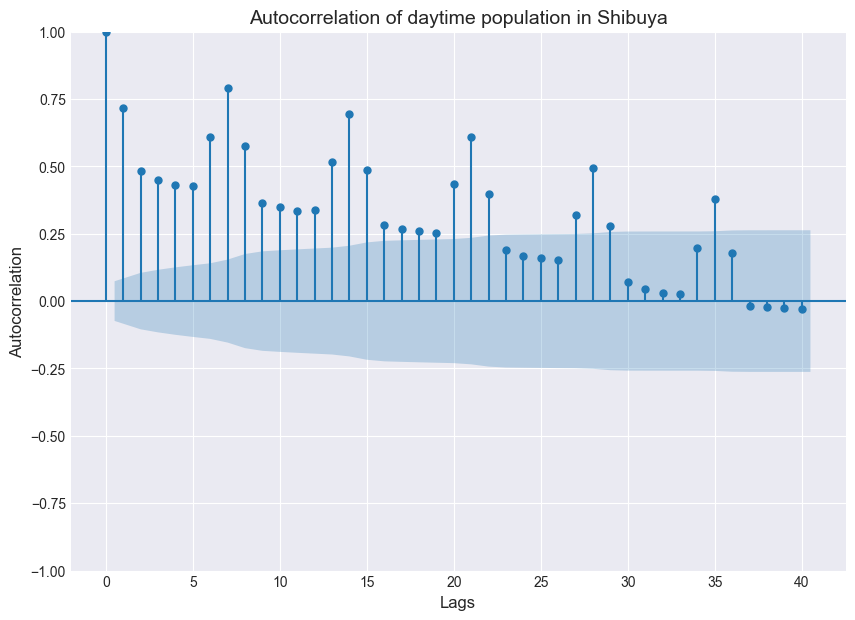

In [22]:
################################
## VISUALIZING AUTOCORRELATION IN DATA 
################################

# Import pandas
import pandas as pd

# reg_df

# Import matplotlib and set the style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# Import plot_acf from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

plt.rc("figure", figsize=(10, 7))
# Plot ACF of population_log for past 40 lags
plot_acf(reg_df.population_log, lags=40)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of daytime population in Shibuya', fontsize=14)
plt.show()

In [23]:
# using daily difference (strong) 
# SHIBUYA


# read articles into dataframe 
cov_articles = filter_kansenshasuu_articles(articles)
cov_articles['date'] = pd.to_datetime(cov_articles['date'])
cov_articles = pd.DataFrame(cov_articles.groupby('date')['num_publications_reporting'].first())

# read ntt data
df = pd.read_csv(NTT_PATH.format("shibuya_station_1_refined_binned"))
# set time_bin
daytime = df[df["time_bin"] == "800-1700"].reset_index(drop=True)
# add population_log 
daytime["population_log"] = daytime["population"].apply(math.log)
# convert date to datetime 
daytime["date"] = pd.to_datetime(daytime["date"])
# merge ntt and articles df 
daytime = daytime.merge(cov_articles, how="left", on="date")
daytime["num_publications_reporting"] = daytime["num_publications_reporting"].fillna(0).apply(int)
# set date as index
daytime.set_index('date', inplace=True)
# create lag variables
daytime['population_diff'] = daytime['population'].diff(1)
daytime['population_diff_lag'] = daytime['population_diff'].shift(1)
daytime['population_log_diff'] = daytime['population_log'].diff(1)
daytime['population_log_diff_lag'] = daytime['population_log_diff'].shift(1)
daytime['population_lag'] = daytime['population'].shift(1)
daytime['population_log_lag'] = daytime['population_log'].shift(1)
daytime['tokyo_new_cases_lag'] = daytime['tokyo_new_cases'].shift(1)
daytime['tokyo_new_cases_week_lag'] = daytime['tokyo_new_cases'].shift(7)

# get regression data 
mask = ['population_diff', 'population_diff_lag', 'population_log_diff', 'population_log_diff_lag',
        'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag']

# add weather dummies
mask += list(daytime.columns[daytime.columns.str.contains(r"weather_\d+")])

# add soe dummies
mask += list(daytime.columns[daytime.columns.str.contains(r"soe\d+")])

# add wave dummies
mask += list(daytime.columns[daytime.columns.str.contains(r"wave\d+")])

# add weekday dummies
mask += list(daytime.columns[daytime.columns.str.contains(r"weekday_\d+")])

print(mask) 

# prepare data for linear regression
reg_df = daytime[mask]

reg_df = reg_df.dropna(axis=0)

# add urgency score to reg_df 
# create urgency dummy
cov_articles["urgency"] = cov_articles["num_publications_reporting"].apply(lambda x: int(x>=3))

reg_df1 = reg_df.merge(cov_articles, how="left", on="date")
reg_df1['urgency'] = reg_df1['urgency'].fillna(0).apply(int)
reg_df1['num_publications_reporting'] = reg_df1['num_publications_reporting'].fillna(0).apply(int)

reg_df1 = reg_df1.dropna(axis=0)


X = reg_df1.drop(['population_diff', 'urgency', 'population_log_diff', 'population_log_diff_lag'], axis=1)
y = reg_df1['population_diff']

# add constant to the model
X = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

# summary of the model
print(model.summary())


X = reg_df1.drop(['population_log_diff', 'urgency', 'population_diff', 'population_diff_lag'], axis=1)
y = reg_df1['population_log_diff']

# add constant to the model
X = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

# summary of the model
print(model.summary())

['population_diff', 'population_diff_lag', 'population_log_diff', 'population_log_diff_lag', 'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'weather_9', 'weather_10', 'weather_15', 'soe1', 'soe2', 'soe3', 'soe4', 'semi-soe1', 'semi-soe2', 'wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
                            OLS Regression Results                            
Dep. Variable:        population_diff   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     143.7
Date:                Mon, 30 Jan 2023   Prob (F-statistic):          1.55e-256
Time:                        18:08:15   Log-Likelihood:                -7636.8
No. Observations:                 709   AIC:                         1.533e+04
Df Re

In [38]:
# using daily difference (strong) 
# TOKYO_OOTEMACHI


# read articles into dataframe 
cov_articles = filter_kansenshasuu_articles(articles)
cov_articles['date'] = pd.to_datetime(cov_articles['date'])
cov_articles = pd.DataFrame(cov_articles.groupby('date')['num_publications_reporting'].first())

# read ntt data
df = pd.read_csv(NTT_PATH.format("tokyo_ootemachi_refined_binned"))
# set time_bin
daytime = df[df["time_bin"] == "800-1700"].reset_index(drop=True)
# add population_log 
daytime["population_log"] = daytime["population"].apply(math.log)
# convert date to datetime 
daytime["date"] = pd.to_datetime(daytime["date"])
# merge ntt and articles df 
daytime = daytime.merge(cov_articles, how="left", on="date")
daytime["num_publications_reporting"] = daytime["num_publications_reporting"].fillna(0).apply(int)
# set date as index
daytime.set_index('date', inplace=True)
# create lag variables
daytime['population_diff'] = daytime['population'].diff(1)
daytime['population_diff_lag'] = daytime['population_diff'].shift(1)
daytime['population_log_diff'] = daytime['population_log'].diff(1)
daytime['population_log_diff_lag'] = daytime['population_log_diff'].shift(1)
daytime['population_lag'] = daytime['population'].shift(1)
daytime['population_log_lag'] = daytime['population_log'].shift(1)
daytime['tokyo_new_cases_lag'] = daytime['tokyo_new_cases'].shift(1)
daytime['tokyo_new_cases_week_lag'] = daytime['tokyo_new_cases'].shift(7)

# get regression data 
mask = ['population_diff', 'population_diff_lag', 'population_log_diff', 'population_log_diff_lag',
        'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag']

# add weather dummies
mask += list(daytime.columns[daytime.columns.str.contains(r"weather_\d+")])

# add soe dummies
mask += list(daytime.columns[daytime.columns.str.contains(r"soe\d+")])

# add wave dummies
mask += list(daytime.columns[daytime.columns.str.contains(r"wave\d+")])

# add weekday dummies
mask += list(daytime.columns[daytime.columns.str.contains(r"weekday_\d+")])

print(mask) 

# prepare data for linear regression
reg_df = daytime[mask]

reg_df = reg_df.dropna(axis=0)

# add urgency score to reg_df 
# create urgency dummy
cov_articles["urgency"] = cov_articles["num_publications_reporting"].apply(lambda x: int(x>=3))

reg_df1 = reg_df.merge(cov_articles, how="left", on="date")
reg_df1['urgency'] = reg_df1['urgency'].fillna(0).apply(int)
reg_df1['num_publications_reporting'] = reg_df1['num_publications_reporting'].fillna(0).apply(int)

reg_df1 = reg_df1.dropna(axis=0)


X = reg_df1.drop(['population_diff', 'urgency', 'population_log_diff', 'population_log_diff_lag'], axis=1)
y = reg_df1['population_diff']

# add constant to the model
X = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

# summary of the model
print(model.summary())


X = reg_df1.drop(['population_log_diff', 'urgency', 'population_diff', 'population_diff_lag'], axis=1)
y = reg_df1['population_log_diff']

# add constant to the model
X = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

# summary of the model
print(model.summary())

['population_diff', 'population_diff_lag', 'population_log_diff', 'population_log_diff_lag', 'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'weather_9', 'weather_10', 'weather_15', 'soe1', 'soe2', 'soe3', 'soe4', 'semi-soe1', 'semi-soe2', 'wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
                            OLS Regression Results                            
Dep. Variable:        population_diff   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     168.4
Date:                Mon, 30 Jan 2023   Prob (F-statistic):          1.78e-276
Time:                        18:35:44   Log-Likelihood:                -8285.4
No. Observations:                 709   AIC:                         1.662e+04
Df Re

In [25]:
# using weekly difference  (terrible)


# read articles into dataframe 
cov_articles = filter_kansenshasuu_articles(articles)
cov_articles['date'] = pd.to_datetime(cov_articles['date'])
cov_articles = pd.DataFrame(cov_articles.groupby('date')['num_publications_reporting'].first())

# read ntt data
df = pd.read_csv(NTT_PATH.format("tokyo_ootemachi_refined_binned"))
# set time_bin
daytime = df[df["time_bin"] == "800-1700"].reset_index(drop=True)
# add population_log 
daytime["population_log"] = daytime["population"].apply(math.log)
# convert date to datetime 
daytime["date"] = pd.to_datetime(daytime["date"])
# merge ntt and articles df 
daytime = daytime.merge(cov_articles, how="left", on="date")
daytime["num_publications_reporting"] = daytime["num_publications_reporting"].fillna(0).apply(int)
# set date as index
daytime.set_index('date', inplace=True)
# create lag variables
daytime['population_diff'] = daytime['population'].diff(7)
daytime['population_diff_lag'] = daytime['population_diff'].shift(1)
daytime['population_log_diff'] = daytime['population_log'].diff(7)
daytime['population_log_diff_lag'] = daytime['population_log_diff'].shift(1)
daytime['population_lag'] = daytime['population'].shift(1)
daytime['population_log_lag'] = daytime['population_log'].shift(1)
daytime['tokyo_new_cases_lag'] = daytime['tokyo_new_cases'].shift(1)
daytime['tokyo_new_cases_week_lag'] = daytime['tokyo_new_cases'].shift(7)

# get regression data 
mask = ['population_diff', 'population_diff_lag', 'population_log_diff', 'population_log_diff_lag',
        'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag']

# add weather dummies
mask += list(daytime.columns[daytime.columns.str.contains(r"weather_\d+")])

# add soe dummies
mask += list(daytime.columns[daytime.columns.str.contains(r"soe\d+")])

# add wave dummies
mask += list(daytime.columns[daytime.columns.str.contains(r"wave\d+")])

# add weekday dummies
mask += list(daytime.columns[daytime.columns.str.contains(r"weekday_\d+")])

print(mask) 

# prepare data for linear regression
reg_df = daytime[mask]

reg_df = reg_df.dropna(axis=0)

# add urgency score to reg_df 
# create urgency dummy
cov_articles["urgency"] = cov_articles["num_publications_reporting"].apply(lambda x: int(x>=3))

reg_df1 = reg_df.merge(cov_articles, how="left", on="date")
reg_df1['urgency'] = reg_df1['urgency'].fillna(0).apply(int)
reg_df1['num_publications_reporting'] = reg_df1['num_publications_reporting'].fillna(0).apply(int)

reg_df1 = reg_df1.dropna(axis=0)


X = reg_df1.drop(['population_diff', 'urgency', 'population_log_diff', 'population_log_diff_lag'], axis=1)
y = reg_df1['population_diff']

# add constant to the model
X = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

# summary of the model
print(model.summary())


X = reg_df1.drop(['population_log_diff', 'urgency', 'population_diff', 'population_diff_lag'], axis=1)
y = reg_df1['population_log_diff']

# add constant to the model
X = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

# summary of the model
print(model.summary())

['population_diff', 'population_diff_lag', 'population_log_diff', 'population_log_diff_lag', 'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'weather_9', 'weather_10', 'weather_15', 'soe1', 'soe2', 'soe3', 'soe4', 'semi-soe1', 'semi-soe2', 'wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
                            OLS Regression Results                            
Dep. Variable:        population_diff   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     18.95
Date:                Mon, 30 Jan 2023   Prob (F-statistic):           5.93e-64
Time:                        18:08:16   Log-Likelihood:                -8396.9
No. Observations:                 709   AIC:                         1.685e+04
Df Re

In [122]:
# Import adfuller
from statsmodels.tsa.stattools import adfuller
daytime = pd.read_csv("./data/ntt_data/daytime_agg.csv")

result = adfuller(daytime.shibuya)
print('p-value: %.2f' % result[1])

p-value: 0.09


In [123]:
# log transform the original columns
daytime['shibuya_log'] = np.log(daytime['shibuya'])
daytime['ootemachi_log'] = np.log(daytime['ootemachi'])
daytime['kiyose_log'] = np.log(daytime['kiyose'])

result = adfuller(daytime.shibuya_log)
print(f'Shibuya \tTest statistic: {round(result[0], 2)} \n \t \tp-value: {round(result[1], 2)}')
result = adfuller(daytime.ootemachi_log)
print(f'Ootemachi \tTest statistic: {round(result[0], 2)} \n \t \tp-value: {round(result[1], 2)}')
result = adfuller(daytime.kiyose_log)
print(f'Kiyose \t\tTest statistic: {round(result[0], 2)} \n \t \tp-value: {round(result[1], 2)}')

Shibuya 	Test statistic: -2.56 
 	 	p-value: 0.1
Ootemachi 	Test statistic: -2.66 
 	 	p-value: 0.08
Kiyose 		Test statistic: -2.54 
 	 	p-value: 0.11


In [124]:
# compute log differences
daytime['shibuya_log_diff'] = daytime['shibuya_log'].diff()
daytime['ootemachi_log_diff'] = daytime['ootemachi_log'].diff()
daytime['kiyose_log_diff'] = daytime['kiyose_log'].diff()
daytime = daytime.dropna(axis=0)

result = adfuller(daytime.shibuya_log_diff)
print(f'Shibuya \tTest statistic: {round(result[0], 2)} \n \t \tp-value: {round(result[1], 2)}')
result = adfuller(daytime.ootemachi_log_diff)
print(f'Ootemachi \tTest statistic: {round(result[0], 2)} \n \t \tp-value: {round(result[1], 2)}')
result = adfuller(daytime.kiyose_log_diff)
print(f'Kiyose \t\tTest statistic: {round(result[0], 2)} \n \t \tp-value: {round(result[1], 2)}')

Shibuya 	Test statistic: -6.1 
 	 	p-value: 0.0
Ootemachi 	Test statistic: -7.85 
 	 	p-value: 0.0
Kiyose 		Test statistic: -8.12 
 	 	p-value: 0.0


In [144]:
modshib = placebo_test("shibuya_station_1_refined_binned", "urgency_scores", "800-1700", "population_log_diff", "population_log_diff_lag", interactions=False, lags = 2)
modotemachi = placebo_test("tokyo_ootemachi_refined_binned", "urgency_scores", "800-1700", "population_log_diff", "population_log_diff_lag", interactions=False, lags = 2)
modkiyose = placebo_test("kiyose_jutakugai_refined_binned", "urgency_scores", "800-1700", "population_log_diff", "population_log_diff_lag", interactions=False, lags = 2)

print(mod.summary().as_latex())

['population_log_diff', 'population_log_diff_lag', 'news_urgency', 'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'weather_9', 'weather_10', 'weather_15', 'soe1', 'soe2', 'soe3', 'soe4', 'semi-soe1', 'semi-soe2', 'wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
                             OLS Regression Results                            
Dep. Variable:     population_log_diff   R-squared:                       0.123
Model:                             OLS   Adj. R-squared:                  0.090
Method:                  Least Squares   F-statistic:                     3.680
Date:                 Wed, 01 Feb 2023   Prob (F-statistic):           3.73e-09
Time:                         12:35:46   Log-Likelihood:                 1233.5
No. Observations:                  707   AIC:                            -2413.
Df Residuals:           

In [145]:
from stargazer.stargazer import Stargazer
star = Stargazer([modshib, modotemachi, modkiyose])
print(star.render_latex())


\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable:}} \
\cr \cline{3-4}
\\[-1.8ex] & (1) & (2) & (3) \\
\hline \\[-1.8ex]
 const & -0.005$^{}$ & -0.005$^{}$ & -0.005$^{}$ \\
  & (0.014) & (0.014) & (0.014) \\
 holiday & -0.010$^{}$ & -0.010$^{}$ & -0.010$^{}$ \\
  & (0.008) & (0.008) & (0.008) \\
 news_urgency & 0.002$^{}$ & 0.002$^{}$ & 0.002$^{}$ \\
  & (0.002) & (0.002) & (0.002) \\
 population_log_diff_lag & -0.126$^{***}$ & -0.126$^{***}$ & -0.126$^{***}$ \\
  & (0.038) & (0.038) & (0.038) \\
 semi-soe1 & 0.005$^{}$ & 0.005$^{}$ & 0.005$^{}$ \\
  & (0.014) & (0.014) & (0.014) \\
 semi-soe2 & -0.001$^{}$ & -0.001$^{}$ & -0.001$^{}$ \\
  & (0.011) & (0.011) & (0.011) \\
 soe1 & 0.000$^{}$ & 0.000$^{}$ & 0.000$^{}$ \\
  & (0.008) & (0.008) & (0.008) \\
 soe2 & 0.010$^{}$ & 0.010$^{}$ & 0.010$^{}$ \\
  & (0.007) & (0.007) & (0.007) \\
 soe3 & 0.004$^{}$ & 0.004$^{}$ & 0.004$^{}$ \

In [129]:
def perform_regression_1(pop_filename: str, urgency_filename:str, time_bin: str, y: str, y_lag: str, interactions: bool = False):
    # read articles into dataframe 
    urgency_scores = pd.read_csv(NEWS_PATH.format(urgency_filename))
    urgency_scores['date'] = pd.to_datetime(urgency_scores['date'])

    # read ntt data
    df = pd.read_csv(NTT_PATH.format(pop_filename))
    # set time_bin
    daytime = df[df["time_bin"] == time_bin].reset_index(drop=True)
    # add population_log 
    daytime["population_log"] = daytime["population"].apply(math.log)
    # convert date to datetime 
    daytime["date"] = pd.to_datetime(daytime["date"])
    # merge ntt and articles df 
    daytime = daytime.merge(urgency_scores, how="left", on="date")
    daytime["news_urgency"] = daytime["news_urgency"].fillna(0).apply(int)
    # set date as index
    daytime.set_index('date', inplace=True)
    # create lag variables
    daytime['population_diff'] = daytime['population'].diff(1)
    daytime['population_diff_lag'] = daytime['population_diff'].shift(1)
    daytime['population_log_diff'] = daytime['population_log'].diff(1)
    daytime['population_log_diff_lag'] = daytime['population_log_diff'].shift(1)
    daytime['population_diff_log'] = daytime['population_diff'].apply(np.log)
    daytime['population_diff_log_lag'] = daytime['population_diff_log'].shift(1)
    daytime['population_lag'] = daytime['population'].shift(1)
    daytime['population_log_lag'] = daytime['population_log'].shift(1)
    daytime['tokyo_new_cases_lag'] = daytime['tokyo_new_cases'].shift(1)
    daytime['tokyo_new_cases_week_lag'] = daytime['tokyo_new_cases'].shift(7)
    daytime['total_new_cases_lag'] = daytime['total_new_cases'].shift(1)
    daytime['total_new_cases_week_lag'] = daytime['total_new_cases'].shift(7)
    
    # get regression data 
    mask = [y, y_lag, 'news_urgency',
            'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag']

    # add weather dummies
    mask += list(daytime.columns[daytime.columns.str.contains(r"weather_\d+")])

    # add soe dummies
    mask += list(daytime.columns[daytime.columns.str.contains(r"soe\d+")])

    # add wave dummies
    mask += list(daytime.columns[daytime.columns.str.contains(r"wave\d+")])

    # add weekday dummies
    mask += list(daytime.columns[daytime.columns.str.contains(r"weekday_\d+")])

    print(mask) 

    # prepare data for linear regression
    reg_df = daytime[mask]

    reg_df = reg_df.dropna(axis=0)
    
    if interactions: 
        # Create interaction columns for each interaction between a wave and news_urgency
        for wave in ['wave1', 'wave2', 'wave3', 'wave4', 'wave5']:
                reg_df[f"{wave}_x_news_urgency"] = reg_df[wave] * reg_df["news_urgency"]

    # prepare x and y 
    X = reg_df.drop([y], axis=1)
    y = reg_df[y]
    
    # add constant to the model
    X = sm.add_constant(X)

    # fit the model
    model = sm.OLS(y, X).fit()

    # summary of the model
    print(model.summary())

    return model



In [87]:
def placebo_test(pop_filename: str, urgency_filename: str, time_bin: str, y: str, y_lag: str, interactions: bool = False, lags: int=2):

    urgency_scores = pd.read_csv(NEWS_PATH.format("urgency_scores"))
    urgency_scores['date'] = pd.to_datetime(urgency_scores['date'])
    
    # read ntt data
    df = pd.read_csv(NTT_PATH.format(pop_filename))
    # set time_bin
    daytime = df[df["time_bin"] == "800-1700"].reset_index(drop=True)
    # add population_log 
    daytime["population_log"] = daytime["population"].apply(math.log)
    # convert date to datetime 
    daytime["date"] = pd.to_datetime(daytime["date"])
    # merge ntt and articles df 
    daytime = daytime.merge(urgency_scores, how="left", on="date")
    daytime["news_urgency"] = daytime["news_urgency"].fillna(0).apply(int)
    # set date as index
    daytime.set_index('date', inplace=True)
    # create lag variables
    daytime['population_diff'] = daytime['population'].diff(1)
    daytime['population_diff_lag'] = daytime['population_diff'].shift(1)
    daytime['population_log_diff'] = daytime['population_log'].diff(1)
    daytime['population_log_diff_lag'] = daytime['population_log_diff'].shift(1)
    daytime['population_lag'] = daytime['population'].shift(1)
    daytime['population_log_lag'] = daytime['population_log'].shift(1)
    daytime['tokyo_new_cases_lag'] = daytime['tokyo_new_cases'].shift(1)
    daytime['tokyo_new_cases_week_lag'] = daytime['tokyo_new_cases'].shift(7)
    
    # get regression data 
    mask = [y, y_lag, 'news_urgency', 
            'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag']
    
    # add weather dummies
    mask += list(daytime.columns[daytime.columns.str.contains(r"weather_\d+")])
    
    # add soe dummies
    mask += list(daytime.columns[daytime.columns.str.contains(r"soe\d+")])
    
    # add wave dummies
    mask += list(daytime.columns[daytime.columns.str.contains(r"wave\d+")])
    
    # add weekday dummies
    mask += list(daytime.columns[daytime.columns.str.contains(r"weekday_\d+")])
    
    print(mask) 
    
    # prepare data for linear regression
    reg_df = daytime[mask]
    
    reg_df = reg_df.dropna(axis=0)
    
    reg_df_shifted = reg_df.shift(lags)
    
    reg_df_shifted["news_urgency"] = reg_df["news_urgency"]
    
    reg_df_shifted = reg_df_shifted.dropna(axis=0)
    
    reg_df_shifted
    
    # prepare x and y 
    X = reg_df_shifted.drop([y], axis=1)
    y = reg_df_shifted[y]
    
    # add constant to the model
    X = sm.add_constant(X)
    
    # fit the model
    model = sm.OLS(y, X).fit()
    
    # summary of the model
    print(model.summary())

    return model
    

In [96]:
placebo_test("kiyose_jutakugai_refined_binned", "urgency_scores", "800-1700", "population_diff", "population_diff_lag", interactions=False, lags = 2)

['population_diff', 'population_diff_lag', 'news_urgency', 'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'weather_9', 'weather_10', 'weather_15', 'soe1', 'soe2', 'soe3', 'soe4', 'semi-soe1', 'semi-soe2', 'wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
                            OLS Regression Results                            
Dep. Variable:        population_diff   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     6.057
Date:                Tue, 31 Jan 2023   Prob (F-statistic):           2.51e-18
Time:                        12:25:55   Log-Likelihood:                -5801.6
No. Observations:                 707   AIC:                         1.166e+04
Df Residuals:                     680  